# <b>Część praktyczna pracy inżynierskiej</b>
<b>Temat pracy:</b> Opracowanie modelu predykcyjnego określającego wartość używanego pojazdu na podstawie jego danych technicznych<br>
<b>Autor:</b> Bartosz Faltynowski<br>
<b>Promotor:</b> dr inż Damian Ledziński
<b>Zbiór danych dostępny pod adresem:</b>

https://www.kaggle.com/datasets/bartoszpieniak/poland-cars-for-sale-dataset/data

# Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor


# Import zbioru danych

In [2]:
data_path = 'Car_sale_ads.csv'
df = pd.read_csv(data_path)

# Podstawowe informacje

## Rozmiar zbioru

In [3]:
df.shape

(208304, 25)

## Przegląd pierwszych wierszy

In [4]:
df.head()

Index  Price Currency Condition Vehicle_brand Vehicle_model   
0      0  86200      PLN       New        Abarth           595  \
1      1  43500      PLN      Used        Abarth         Other   
2      2  44900      PLN      Used        Abarth           500   
3      3  39900      PLN      Used        Abarth           500   
4      4  97900      PLN       New        Abarth           595   

  Vehicle_version Vehicle_generation  Production_year  Mileage_km  ...   
0             NaN                NaN             2021         1.0  ...  \
1             NaN                NaN             1974     59000.0  ...   
2             NaN                NaN             2018     52000.0  ...   
3             NaN                NaN             2012     29000.0  ...   
4             NaN                NaN             2021       600.0  ...   

   Transmission        Type Doors_number  Colour Origin_country First_owner   
0        Manual  small_cars          3.0    gray            NaN         NaN  \
1        Manual       coupe          2.0  silver            NaN         NaN   
2     Automatic  small_cars          3.0  silver            NaN         NaN   
3        Manual  small_cars          3.0    gray            NaN         NaN   
4        Manual  small_cars          3.0    blue            NaN         NaN   

  First_registration_date  Offer_publication_date   
0                     NaN              04/05/2021  \
1                     NaN              03/05/2021   
2                     NaN              03/05/2021   
3                     NaN              30/04/2021   
4                     NaN              30/04/2021   

                                      Offer_location   
0  ul. Jubilerska 6 - 04-190 Warszawa, Mazowiecki...  \
1  kanonierska12 - 04-425 Warszawa, Rembertów (Po...   
2                   Warszawa, Mazowieckie, Białołęka   
3                                  Jaworzno, Śląskie   
4  ul. Gorzysława 9 - 61-057 Poznań, Nowe Miasto ...   

                                            Features  
0                                                 []  
1                                                 []  
2  ['ABS', 'Electric front windows', 'Drivers air...  
3  ['ABS', 'Electric front windows', 'Drivers air...  
4  ['ABS', 'Electrically adjustable mirrors', 'Pa...  

[5 rows x 25 columns]

## Typy danych

In [5]:
df.dtypes

Index                        int64
Price                        int64
Currency                    object
Condition                   object
Vehicle_brand               object
Vehicle_model               object
Vehicle_version             object
Vehicle_generation          object
Production_year              int64
Mileage_km                 float64
Power_HP                   float64
Displacement_cm3           float64
Fuel_type                   object
CO2_emissions              float64
Drive                       object
Transmission                object
Type                        object
Doors_number               float64
Colour                      object
Origin_country              object
First_owner                 object
First_registration_date     object
Offer_publication_date      object
Offer_location              object
Features                    object
dtype: object

## Ilość unikalnych wartości

In [6]:
df.nunique()

Index                      208304
Price                       14142
Currency                        2
Condition                       2
Vehicle_brand                 108
Vehicle_model                1203
Vehicle_version             19056
Vehicle_generation            569
Production_year                92
Mileage_km                  52007
Power_HP                      573
Displacement_cm3             1181
Fuel_type                       8
CO2_emissions                 372
Drive                           5
Transmission                    2
Type                            9
Doors_number                   10
Colour                         14
Origin_country                 37
First_owner                     1
First_registration_date      8441
Offer_publication_date         41
Offer_location              13635
Features                   177211
dtype: int64

## Wartości puste

In [7]:
df.isnull().sum()

Index                           0
Price                           0
Currency                        0
Condition                       0
Vehicle_brand                   0
Vehicle_model                   0
Vehicle_version             70222
Vehicle_generation          60444
Production_year                 0
Mileage_km                    983
Power_HP                      643
Displacement_cm3             1966
Fuel_type                       0
CO2_emissions              114257
Drive                       15076
Transmission                  479
Type                            0
Doors_number                 1487
Colour                          0
Origin_country              89992
First_owner                143210
First_registration_date    121859
Offer_publication_date          0
Offer_location                  0
Features                        0
dtype: int64

## Analiza statystyczna zmiennych numerycznych

In [8]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [9]:
# Wybór kolumn numerycznych do analizy wartości odstających

numeric_columns = ['Price','Mileage_km', 'Power_HP', 'Displacement_cm3']
df[numeric_columns].describe()

Price    Mileage_km  Power_HP  Displacement_cm3
count  208304.00     207321.00 207661.00         206338.00
mean    63053.83     150276.76    151.84           1882.57
std     86659.67    2937446.81     77.68            729.61
min       500.00          1.00      1.00            400.00
25%     17800.00      53000.00    105.00           1461.00
50%     35700.00     144566.00    136.00           1798.00
75%     75990.00     206000.00    172.00           1997.00
max   6999000.00 1111111111.00   1398.00           8400.00

In [10]:
pd.reset_option('display.float_format')

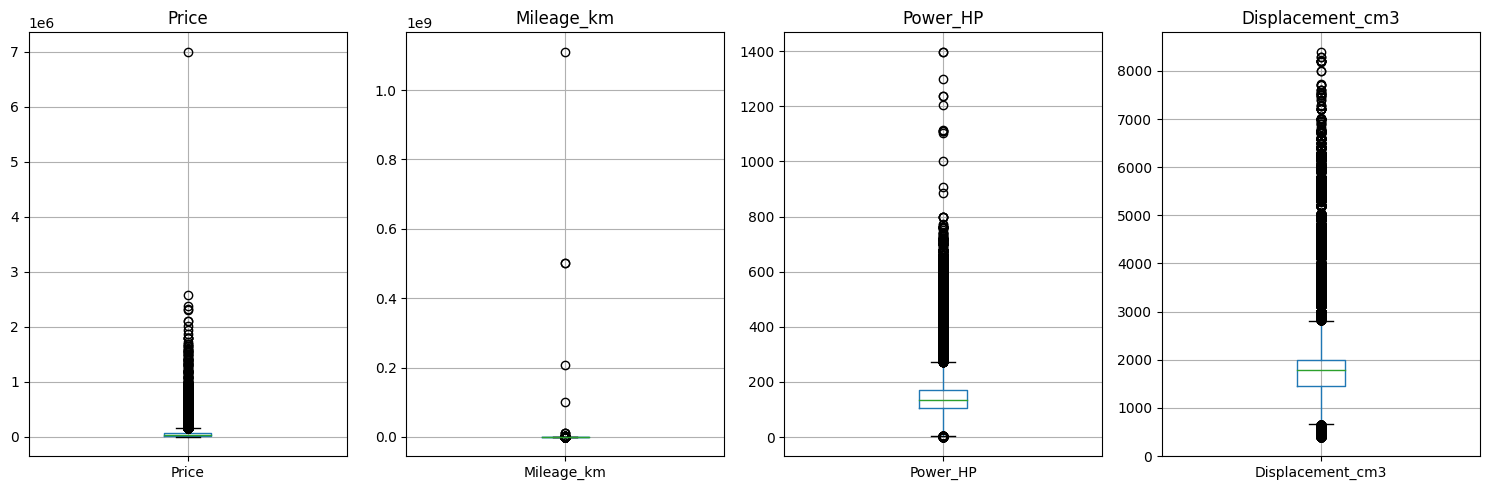

In [11]:
# Tworzenie wykresów pudełkowych dla kolumn numerycznych
plt.figure(figsize=(15, 5))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(1, len(numeric_columns), i)
    df.boxplot(column=col)
    plt.title(col)

plt.tight_layout()
plt.show()

## Preprocessing przed dalszą analizą

In [12]:
df[df["Price"]>3000000]

Index    Price Currency Condition Vehicle_brand Vehicle_model   
32304  32304  6999000      PLN      Used           BMW            X3  \

      Vehicle_version Vehicle_generation  Production_year  Mileage_km  ...   
32304             NaN        F25 (2010-)             2014    238000.0  ...  \

       Transmission  Type Doors_number  Colour Origin_country First_owner   
32304     Automatic   SUV          5.0  silver            NaN         NaN  \

      First_registration_date  Offer_publication_date   
32304                     NaN              04/05/2021  \

                                          Offer_location   
32304  ŁYSKOWSKIEGO, 55B - 86-300 Grudziądz, Kujawsko...  \

                                                Features  
32304  ['ABS', 'Central locking', 'Electric rear wind...  

[1 rows x 25 columns]

Aktualnie samochód zbliżony technicznie do wymienionego posiada cenę do 120000 PLN. Należy uznać ten wiersz jako błędny i go usunąć.

In [13]:
df=df[df["Price"]<=3000000]

In [14]:
df[df["Mileage_km"]>=1000000]

Index   Price Currency Condition  Vehicle_brand Vehicle_model   
261        261   11999      PLN      Used     Alfa Romeo           159  \
4863      4863   13200      PLN      Used           Audi            A4   
9811      9811   56900      PLN      Used           Audi            A5   
14209    14209   19500      PLN      Used           Audi            A8   
19053    19053   31000      PLN      Used            BMW            M3   
19489    19489   34500      PLN      Used            BMW       Seria 1   
37032    37032   11000      PLN      Used       Chrysler    New Yorker   
47200    47200   13500      PLN      Used          Dodge       Caliber   
63123    63123   21999      PLN      Used           Ford        Mondeo   
66255    66255  117000      PLN      Used           Ford       Mustang   
69129    69129    7999      PLN      Used            Gaz            69   
79500    79500   49999      PLN      Used         Jaguar            XF   
80028    80028  199000      PLN      Used         Jaguar        E-Type   
85929    85929    3200      PLN      Used            Kia       Sorento   
91870    91870    9999      PLN      Used          Mazda             6   
96121    96121   18500      PLN      Used  Mercedes-Benz       Klasa C   
117012  117012    6500      PLN      Used           Opel         Astra   
121804  121804   10900      PLN      Used           Opel         Combo   
125356  125356   28500      PLN      Used           Opel      Insignia   
127757  127757   31980      PLN      Used           Opel        Kadett   
127838  127838    9700      PLN      Used           Opel        Meriva   
132914  132914   33333      PLN      Used      Zaporożec         Other   
132958  132958   79000      PLN      Used           Inny         Other   
133558  133558   11600      PLN      Used        Peugeot           207   
133914  133914   12300      PLN      Used        Peugeot           308   
143373  143373   20000      PLN      Used        Renault          Clio   
144277  144277   18499      PLN      Used        Renault        Scenic   
175640  175640   95000      PLN      Used         Toyota          Aygo   
190587  190587  400000      PLN      Used     Volkswagen          Golf   
192119  192119    6600      PLN      Used     Volkswagen        Passat   
202407  202407   12400      PLN      Used          Volvo           V50   
208029  208029   15800      PLN      Used          Volvo           965   
208293  208293   33333      PLN      Used      Zaporożec         Other   

                  Vehicle_version Vehicle_generation  Production_year   
261            1.9JTDM Impression                NaN             2007  \
4863                   Avant 1.8T     B6 (2000-2004)             2003   
9811                          NaN                NaN             2012   
14209         3.0 TDI DPF quattro     D3 (2002-2010)             2005   
19053                    Standard                NaN             2003   
19489                        116d    F20/F21 (2011-)             2012   
37032                         NaN                NaN             1954   
47200                 2.0 CRD SXT                NaN             2007   
63123           2.0 TDCi Titanium    Mk4 (2007-2014)             2010   
66255                         NaN                NaN             1967   
69129                         NaN                NaN             1970   
79500       4.2 V8 Premium Luxury   X250 (2007-2015)             2009   
80028                         NaN                NaN             1967   
85929              2.5 CRDi (air)      I (2002-2009)             2004   
91870          2.0 CD Top / Sport      I (2002-2008)             2007   
96121                         NaN   W203 (2000-2007)             2005   
117012                        NaN      H (2004-2014)             2007   
121804                   1.7 CDTI      C (2001-2011)             2004   
125356                        NaN      A (2008-2017)             2012   
127757                        Na

In [15]:
df=df[df["Mileage_km"]<1000000]

Ze względu, na bardzo małe prawdopodobieństwo posiadania tak wysokiego przebiegu samochodu, warto usunąć te wiersze.

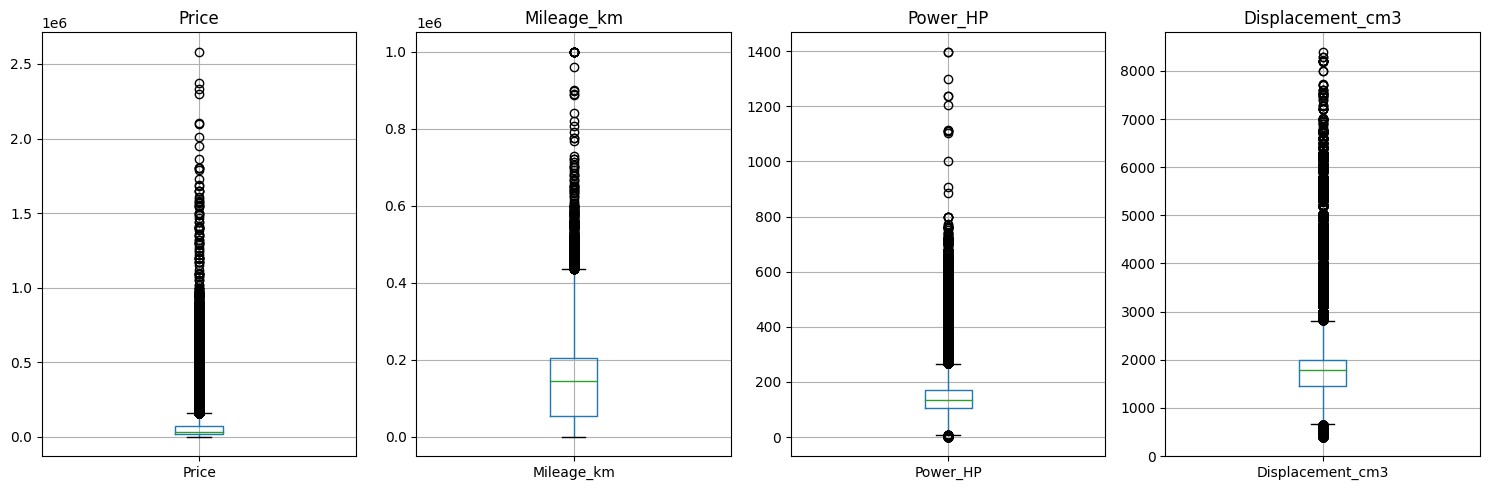

In [16]:
# Tworzenie wykresów pudełkowych dla kolumn numerycznych
plt.figure(figsize=(15, 5))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(1, len(numeric_columns), i)
    df.boxplot(column=col)
    plt.title(col)

plt.tight_layout()
plt.show()

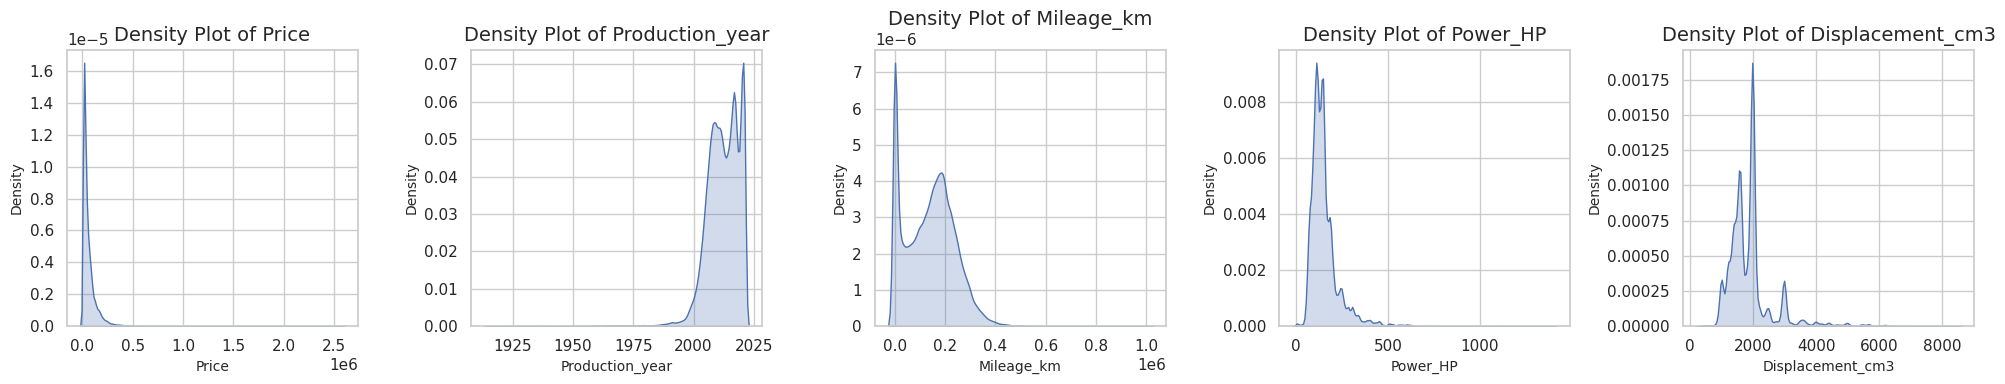

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista kolumn do wizualizacji
columns = ['Price', 'Production_year', 'Mileage_km', 'Power_HP', 'Displacement_cm3']

# Ustawienie stylu wykresu
sns.set(style="whitegrid")

# Tworzenie wykresów KDE dla każdej kolumny w jednym rzędzie
fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(20, 4))  # Zwiększona szerokość figury

for i, column in enumerate(columns):
    sns.kdeplot(df[column], ax=axes[i], fill=True)
    axes[i].set_title(f'Density Plot of {column}', fontsize=14)
    axes[i].set_xlabel(column, fontsize=10)
    axes[i].set_ylabel('Density', fontsize=10)

plt.tight_layout()
plt.show()

## Analiza listy wyposażenia dodatkowego

In [18]:
def remove_brackets(value):
    if isinstance(value, str):
        return value.lstrip('[').rstrip(']')
    return value

df['Features'] = df['Features'].apply(remove_brackets)
df['Features'] = df['Features'].str.replace(" '", "")
df['Features'] = df['Features'].str.replace("'", "")


# Tworzymy zbiór wszystkich unikalnych cech
unique_features_set = set()

for features in df['Features'].dropna():
    features_list = features.split(',')
    unique_features_set.update(features_list)

# Liczba unikalnych dodatkowych wyposażeń
unique_features_count = len(unique_features_set)
unique_features_count


71

In [19]:
unique_features_set

{'',
 'ABS',
 'ASR (traction control)',
 'AUX socket',
 'Active cruise control',
 'Adjustable suspension',
 'Aftermarket radio',
 'Air curtains',
 'Airbag protecting the knees',
 'Alarm',
 'Alloy wheels',
 'Automatic air conditioning',
 'Auxiliary heating',
 'Blind spot sensor',
 'Bluetooth',
 'CD',
 'CD changer',
 'Central locking',
 'Cruise control',
 'DVD player',
 'Daytime running lights',
 'Drivers airbag',
 'Dual zone air conditioning',
 'ESP(stabilization of the track)',
 'Electric front windows',
 'Electric rear windows',
 'Electrically adjustable mirrors',
 'Electrically adjustable seats',
 'Electrochromic rear view mirror',
 'Electrochromic side mirrors',
 'Factory radio',
 'Fog lights',
 'Four-zone air conditioning',
 'Front parking sensors',
 'Front side airbags',
 'GPS navigation',
 'HUD(head-up display)',
 'Heated front seats',
 'Heated rear seats',
 'Heated side mirrors',
 'Heated windscreen',
 'Hook',
 'Immobilizer',
 'Isofix',
 'LED lights',
 'Lane assistant',
 'Leathe

Istnieje 71 unikalnych wartości wyposażenia dodatkowego. Rozbicie tej kolumny na większą ilość kolumn mija się z celem, ponieważ nie jest to tak istotna kolumna. Zamiast tego, zsumujemy ilość dodatkowych wyposażeń każdego auta.

## Currency

In [20]:
df["Currency"].value_counts()

Currency
PLN    207017
EUR       270
Name: count, dtype: int64

## Condition

In [21]:
df["Condition"].value_counts()

Condition
Used    182816
New      24471
Name: count, dtype: int64

## Fuel_type

In [22]:
df["Fuel_type"].value_counts()

Fuel_type
Gasoline          98780
Diesel            92107
Gasoline + LPG     9020
Hybrid             5817
Electric           1491
Gasoline + CNG       70
Hydrogen              2
Name: count, dtype: int64

## Drive

In [23]:
df['Drive'].value_counts()

Drive
Front wheels                    139322
Rear wheels                      18030
4x4 (permanent)                  16930
4x4 (attached automatically)     15165
4x4 (attached manually)           2784
Name: count, dtype: int64

## Transmission

In [24]:
df['Transmission'].value_counts()

Transmission
Manual       132606
Automatic     74205
Name: count, dtype: int64

## Type

In [25]:
df['Type'].value_counts()

Type
SUV              41247
station_wagon    40070
sedan            33085
compact          31957
city_cars        24076
minivan          22081
coupe             6334
small_cars        5956
convertible       2481
Name: count, dtype: int64

## Doors_number

In [26]:
df['Doors_number'].value_counts()

Doors_number
5.0     158030
4.0      27723
3.0      12816
2.0       7189
6.0         51
7.0          8
1.0          4
9.0          2
55.0         2
10.0         1
Name: count, dtype: int64

## Colour

In [27]:
df['Colour'].value_counts()

Colour
black       50125
gray        31618
silver      30807
white       30188
blue        21582
other       13784
red          9729
brown        5537
green        3605
burgundy     3439
golden       2674
beige        2473
yellow        960
violet        766
Name: count, dtype: int64

###  Wizualizacja rozkładu kategorii

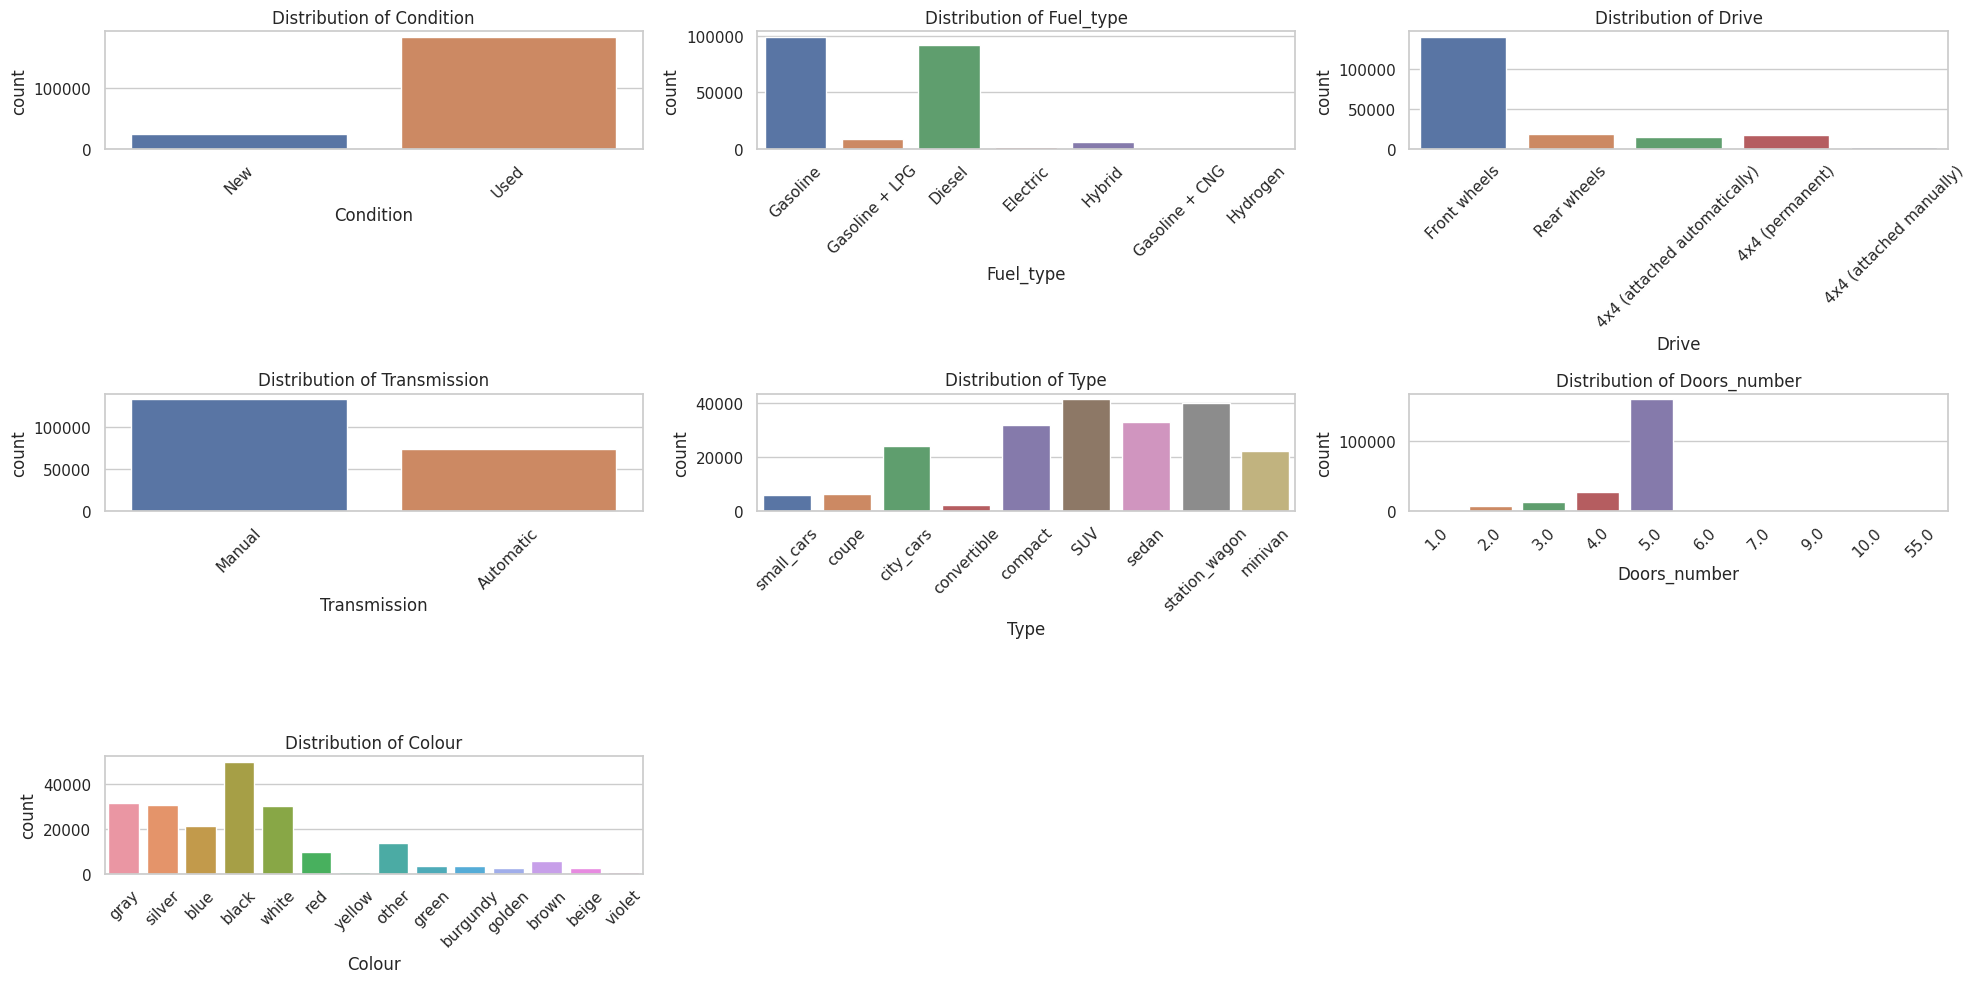

In [28]:
# Definiujemy kategorie, dla których chcemy zobaczyć rozkład
categories = ['Condition', 'Fuel_type', 'Drive', 'Transmission', 'Type', 'Doors_number', 'Colour']

# Ustawiamy wielkość wykresu dla lepszej czytelności
plt.figure(figsize=(20, 10))

for i, category in enumerate(categories, 1):
    plt.subplot(3, 3, i)  # Ustawiamy siatkę wykresów
    sns.countplot(x=category, data=df)
    plt.title(f'Distribution of {category}')
    plt.xticks(rotation=45)  # Obracamy etykiety, aby były czytelne

plt.tight_layout()
plt.show()


# Preprocessing

## Czyszczenie danych

### Index

Wszystkie wartości w kolunie Index są unikatowe, więc ta kolumna nie wnosi nic istotnego do zbioru

In [29]:
# Usunięcie kolumny Index
df = df.drop(columns=['Index'])

### Currency

In [30]:
# Usunięcie wierszy z wartością 'EUR' w kolumnie 'Currency'
df = df[df['Currency'] != 'EUR']

In [31]:
print(df['Currency'].value_counts())

Currency
PLN    207017
Name: count, dtype: int64


In [32]:
# Usunięcie kolumny Currency
df = df.drop(columns=['Currency'])

## Transformacja danych

### Vehicle_brand Vehicle_model

In [33]:
#Połączenie "Vehicle_brand" i "Vehicle_model" w nową kolumnę "brand_model"
df['brand_model'] = df['Vehicle_brand'] + "_" + df['Vehicle_model']

# Usunięcie kolumny brand i model
df = df.drop(columns=['Vehicle_brand','Vehicle_model'])

df.head()


Price Condition Vehicle_version Vehicle_generation  Production_year   
0  86200       New             NaN                NaN             2021  \
1  43500      Used             NaN                NaN             1974   
2  44900      Used             NaN                NaN             2018   
3  39900      Used             NaN                NaN             2012   
4  97900       New             NaN                NaN             2021   

   Mileage_km  Power_HP  Displacement_cm3 Fuel_type  CO2_emissions  ...   
0         1.0     145.0            1400.0  Gasoline            NaN  ...  \
1     59000.0      75.0            1100.0  Gasoline            NaN  ...   
2     52000.0     180.0            1368.0  Gasoline            NaN  ...   
3     29000.0     160.0            1368.0  Gasoline          139.0  ...   
4       600.0     165.0            1368.0  Gasoline            NaN  ...   

         Type Doors_number  Colour  Origin_country First_owner   
0  small_cars          3.0    gray             NaN         NaN  \
1       coupe          2.0  silver             NaN         NaN   
2  small_cars          3.0  silver             NaN         NaN   
3  small_cars          3.0    gray             NaN         NaN   
4  small_cars          3.0    blue             NaN         NaN   

  First_registration_date Offer_publication_date   
0                     NaN             04/05/2021  \
1                     NaN             03/05/2021   
2                     NaN             03/05/2021   
3                     NaN             30/04/2021   
4                     NaN             30/04/2021   

                                      Offer_location   
0  ul. Jubilerska 6 - 04-190 Warszawa, Mazowiecki...  \
1  kanonierska12 - 04-425 Warszawa, Rembertów (Po...   
2                   Warszawa, Mazowieckie, Białołęka   
3                                  Jaworzno, Śląskie   
4  ul. Gorzysława 9 - 61-057 Poznań, Nowe Miasto ...   

                                            Features   brand_model  
0                                                       Abarth_595  
1                                                     Abarth_Other  
2  ABS,Electric front windows,Drivers airbag,Powe...    Abarth_500  
3  ABS,Electric front windows,Drivers airbag,Powe...    Abarth_500  
4  ABS,Electrically adjustable mirrors,Passengers...    Abarth_595  

[5 rows x 22 columns]

In [34]:
# Wykonanie ANOVA
anova_result = stats.f_oneway(*[df['Price'][df['brand_model'] == brand_model] for brand_model in df['brand_model'].unique()])

# Wyświetlenie wyników ANOVA
anova_result


F_onewayResult(statistic=212.47461873410094, pvalue=0.0)

In [35]:
# Wykonanie ANOVA
anova_result = stats.f_oneway(*[df['Price'][df['Offer_location'] == Offer_location] for Offer_location in df['Offer_location'].unique()])

# Wyświetlenie wyników ANOVA
anova_result

F_onewayResult(statistic=18.347540257587088, pvalue=0.0)

In [36]:
df = df.drop(columns=['Offer_location'])

In [37]:
df['brand_model'].nunique()

1305

### Price

In [38]:
df['Price']=np.log(df['Price'])

<Axes: xlabel='Price', ylabel='Density'>

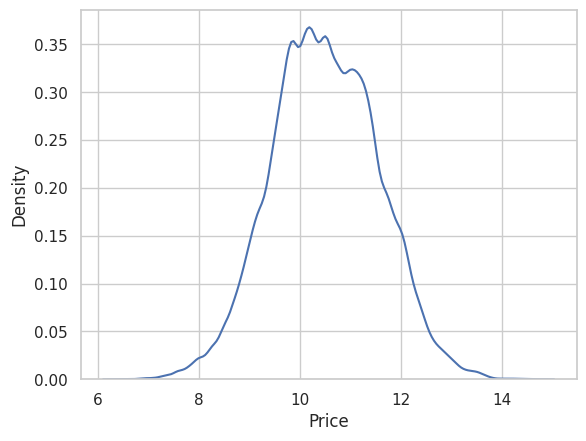

In [39]:
sns.kdeplot(df['Price'])

## Obsługa brakujących danych

### Drive

In [40]:
# Przygotowanie danych do wypełnienia brakujących wartości w 'Drive'

# Grupowanie z uwzględnieniem pełnych informacji, jeśli dostępne
drive_mode_full = df.dropna(subset=['Vehicle_version', 'Vehicle_generation']).groupby(['brand_model', 'Vehicle_version', 'Vehicle_generation'])['Drive'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).to_dict()

# Grupowanie tylko po 'brand_model', jako fallback
drive_mode_brand = df.groupby('brand_model')['Drive'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).to_dict()

def drive_fill(row):
    # Klucz dla pełnej kombinacji
    key_full = (row['brand_model'], row['Vehicle_version'], row['Vehicle_generation'])
    # Jeśli wszystkie elementy klucza są dostępne i odpowiadająca im wartość istnieje
    if key_full in drive_mode_full:
        return drive_mode_full[key_full]
    # Fallback do 'brand_model', jeśli pełna kombinacja nie przynosi rezultatów
    return drive_mode_brand.get(row['brand_model'], row['Drive'])

# Wypełnienie brakujących wartości
df['Drive'] = df.apply(drive_fill, axis=1)

### Transmission

In [41]:
# Przygotowanie danych do wypełnienia brakujących wartości w 'Transmission'

# Grupowanie z uwzględnieniem pełnych informacji, jeśli dostępne
transmission_mode_full = df.dropna(subset=['Vehicle_version', 'Vehicle_generation']).groupby(['brand_model', 'Vehicle_version', 'Vehicle_generation'])['Transmission'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).to_dict()

# Grupowanie tylko po 'brand_model', jako fallback
transmission_mode_brand = df.groupby('brand_model')['Transmission'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).to_dict()

def transmission_fill(row):
    # Klucz dla pełnej kombinacji
    key_full = (row['brand_model'], row['Vehicle_version'], row['Vehicle_generation'])
    # Jeśli wszystkie elementy klucza są dostępne i odpowiadająca im wartość istnieje
    if key_full in transmission_mode_full:
        return transmission_mode_full[key_full]
    # Fallback do 'brand_model', jeśli pełna kombinacja nie przynosi rezultatów
    return transmission_mode_brand.get(row['brand_model'], row['Transmission'])

# Wypełnienie brakujących wartości
df['Transmission'] = df.apply(transmission_fill, axis=1)


In [42]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Vehicle_version             69084
Vehicle_generation          59811
Power_HP                      618
Displacement_cm3             1881
CO2_emissions              113074
Drive                         512
Transmission                   28
Doors_number                 1450
Origin_country              89707
First_owner                141992
First_registration_date    120662
dtype: int64

### Mileage_km, Power_HP, Displacement_cm3, Drive, Transmission

In [43]:
df=df.dropna(subset=['Mileage_km','Power_HP','Displacement_cm3','Drive', 'Transmission'])

In [44]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Vehicle_version             67854
Vehicle_generation          58027
CO2_emissions              110532
Doors_number                 1021
Origin_country              88102
First_owner                140068
First_registration_date    118595
dtype: int64

In [45]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Vehicle_version             67854
Vehicle_generation          58027
CO2_emissions              110532
Doors_number                 1021
Origin_country              88102
First_owner                140068
First_registration_date    118595
dtype: int64

### Doors_number

In [46]:
df_doors = df.dropna(subset=['Doors_number'])

In [47]:
df_doors[df_doors["Doors_number"]>5]

Price Condition Vehicle_version Vehicle_generation   
17907   10.878047      Used             NaN     D3 (2002-2010)  \
36386   10.778956      Used             NaN                NaN   
37618   11.395267      Used             NaN                NaN   
45561   10.122623      Used             NaN                NaN   
45840    9.210240      Used             NaN                NaN   
46656   10.460242      Used             NaN                NaN   
50133    9.539644      Used             NaN                NaN   
52014   11.223909      Used             NaN                NaN   
52544   10.732039      Used             NaN                NaN   
53065   10.081634      Used             NaN         II (2009-)   
68437    8.839277      Used             NaN      I (2002-2013)   
68745   10.817776      Used             NaN         II (2013-)   
68832   10.689670      Used             NaN                NaN   
91349   10.106428      Used             NaN      I (2005-2010)   
92596    8.293800      Used             NaN      I (2005-2010)   
95612   11.134589      Used             NaN                NaN   
105959  10.110502      Used             NaN                NaN   
107935  11.607326       New             NaN                NaN   
108019  12.254387       New             NaN                NaN   
108233  11.511925       New             NaN                NaN   
108274  11.652687       New             NaN                NaN   
108665  11.493304       New             NaN                NaN   
108668  11.960172       New             NaN                NaN   
108675  11.633372       New             NaN                NaN   
108692  11.851538       New             NaN                NaN   
108967  11.506394       New             NaN                NaN   
109110  11.103753      Used             NaN                NaN   
109142  12.071970      Used             NaN                NaN   
109147  12.054668       New             NaN                NaN   
109291  11.406453      Used             NaN        III (2012-)   
130886  10.817776      Used             NaN         II (2014-)   
130988  12.072484       New             NaN         II (2014-)   
131069  12.072484       New             NaN         II (2014-)   
132127   9.210240      Used             NaN      B (2005-2014)   
132277   9.798127      Used             NaN      B (2005-2014)   
132334   9.581904      Used             NaN      B (2005-2014)   
141702   9.928180      Used             NaN                NaN   
144691   8.790269      Used             NaN      I (1998-2008)   
148367  10.491274      Used             NaN         II (2008-)   
149014  10.106428      Used             NaN     II (2001-2014)   
152622  10.043249      Used             NaN     IV (2003-2014)   
153559  10.431170      Used             NaN     II (2001-2014)   
180651  10.643041      Used             NaN    III (2006-2012)   
181315  10.373460      Used             NaN                NaN   
184587  10.038892      Used             NaN        III (2004-)   
184678  11.000432      Used             NaN     IV (2015-2020)   
185152  11.809684       New             NaN                NaN   
185153  11.686274       New             NaN                NaN   
185154  11.476459       New             NaN                NaN   
185270  10.621327      Used             NaN                NaN   
185432  11.943558       New             NaN                NaN   
185433  12.066218       New             NaN                NaN   
185434  12.089084       New             NaN                NaN   
185469  10.941996      Used             NaN                NaN   
186721  10.913269      Used             NaN    VII (2012-2020)   
191434  10.404263      Used             NaN                NaN   
191533  11.241904      Used             NaN                NaN   
191640  11.082127      Used             NaN                NaN   
203716  10.236382      Used             NaN      I (2002-2014)   
207984  11.694413      Used             NaN         

Istnieją modele posiadające więcej niż 5 drzwi (np. busy z dwoma drzwiami z tyłu mają 6 drzwi), natomiast widoczne są w tym przedziale błędne dane. Ze względu na małą ilość pojazdów posiadających więcej niż 5 drzwi, zostaną one usunięte.

In [48]:
df_doors[df_doors["Doors_number"]<=1]

Price Condition Vehicle_version Vehicle_generation   
21153   12.203068       New             NaN                NaN  \
132445  10.594132      Used             NaN                NaN   
183803   7.600902      Used             NaN                NaN   
208299  10.594132      Used             NaN                NaN   

        Production_year  Mileage_km  Power_HP  Displacement_cm3 Fuel_type   
21153              2021        10.0     192.0            1998.0  Gasoline  \
132445             2014     40000.0     173.0            1301.0  Gasoline   
183803             1999     19999.0     199.0            1999.0  Gasoline   
208299             2014     40000.0     173.0            1301.0  Gasoline   

        CO2_emissions  ... Transmission        Type Doors_number  Colour   
21153           140.0  ...    Automatic       coupe          1.0    blue  \
132445            NaN  ...       Manual  small_cars          1.0   other   
183803            NaN  ...       Manual     compact          1.0   other   
208299            NaN  ...       Manual  small_cars          1.0   other   

       Origin_country First_owner First_registration_date   
21153             NaN         NaN                     NaN  \
132445            NaN         NaN                     NaN   
183803         Poland         NaN                     NaN   
208299            NaN         NaN                     NaN   

       Offer_publication_date   
21153              04/05/2021  \
132445             30/04/2021   
183803             30/04/2021   
208299             30/04/2021   

                                                 Features  brand_model  
21153   ABS,Alloy wheels,AUX socket,Cruise control,Ele...  BMW_Seria 2  
132445                                                       Żuk_Other  
183803                                                     Trabant_601  
208299                                                       Żuk_Other  

[4 rows x 21 columns]

In [49]:
df_doors=df_doors[df_doors["Doors_number"]>1]
df_doors=df_doors[df_doors["Doors_number"]<=5]

In [50]:
correlation = df_doors[['Price', 'Doors_number']].corr()
correlation

Price  Doors_number
Price         1.000000      0.065061
Doors_number  0.065061      1.000000

In [51]:
df=df_doors

In [52]:
df = df.drop(columns=['Vehicle_version','Vehicle_generation','CO2_emissions','Origin_country','First_registration_date','Offer_publication_date'])

## Kodowanie cech kategorycznych

### One hot-encoding

In [53]:
df.shape

(203310, 15)

In [54]:
# One-hot encoding dla wybranych kolumn kategorycznych
df = pd.get_dummies(df, columns=[ 'Fuel_type', 'Drive', 'Type','Colour'])

In [55]:
df.shape

(203310, 45)

### Kodowanie Binarne brand_model oraz Offer_location

In [56]:
encoder = ce.BinaryEncoder(cols=['brand_model'])

In [57]:
df = encoder.fit_transform(df,cols=['brand_model'])

In [58]:
df.shape

(203310, 55)

### Przetwarzanie listy Features

In [59]:
# Zliczanie liczby wyposażeń na podstawie liczby przecinków + 1, z wyjątkiem pustych list
df['Features'] = df['Features'].apply(lambda x: x.count(',') + 1 if x != '[]' else 0)

## Usuwanie wartości odstających

### Zastosowanie reguły 3 sigm

In [60]:
def flatten_column(df, column_name):
    mean_value = df[column_name].mean()
    std_value = df[column_name].std()
    highest_value = round(mean_value + 3*std_value, 3)
    lowest_value = round(mean_value - 3*std_value, 3)
    df = df[(df[column_name] > lowest_value) & (df[column_name] < highest_value)]
    return df

columns_to_flatten = ['Price', 'Production_year', 'Mileage_km', 'Power_HP', 'Displacement_cm3']

for column in columns_to_flatten:
    df = flatten_column(df, column)

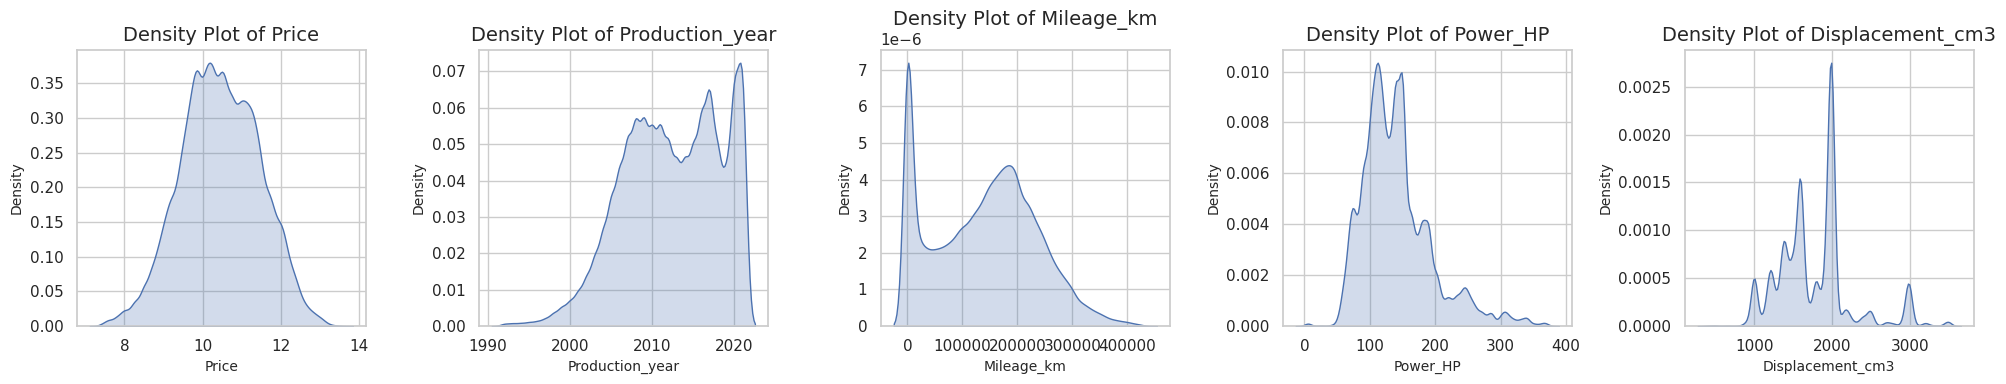

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista kolumn do wizualizacji
columns = ['Price', 'Production_year', 'Mileage_km', 'Power_HP', 'Displacement_cm3']

# Ustawienie stylu wykresu
sns.set(style="whitegrid")

# Tworzenie wykresów KDE dla każdej kolumny w jednym rzędzie
fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(20, 4))  # Zwiększona szerokość figury

for i, column in enumerate(columns):
    sns.kdeplot(df[column], ax=axes[i], fill=True)
    axes[i].set_title(f'Density Plot of {column}', fontsize=14)
    axes[i].set_xlabel(column, fontsize=10)
    axes[i].set_ylabel('Density', fontsize=10)

plt.tight_layout()
plt.show()

## Inżynieria cech

### First_owner

In [62]:
df['First_owner'].unique()

array([nan, 'Yes'], dtype=object)

In [63]:
# Transformacja: 'First_owner' True dla "Yes", False dla braku danych
df['First_owner'] = df['First_owner'].apply(lambda x: True if x == 'Yes' else False)
df['First_owner'].unique()


array([False,  True])

In [64]:
# Transformacja: 'Transmission' True dla "Automatic", False dla "Manual"
df['Transmission'] = df['Transmission'].apply(lambda x: True if x == 'Automatic' else False)
df['Transmission'].unique()

array([False,  True])

In [65]:
# Transformacja: 'Condition'  True dla "New", False dla "Used"
df['Condition'] = df['Condition'].apply(lambda x: True if x == 'New' else False)
df['Condition'].unique()

array([ True, False])

In [66]:
df.nunique()

Price                                 12368
Condition                                 2
Production_year                          30
Mileage_km                            49230
Power_HP                                335
Displacement_cm3                        630
Transmission                              2
Doors_number                              4
First_owner                               2
Features                                 70
brand_model_0                             2
brand_model_1                             2
brand_model_2                             2
brand_model_3                             2
brand_model_4                             2
brand_model_5                             2
brand_model_6                             2
brand_model_7                             2
brand_model_8                             2
brand_model_9                             2
brand_model_10                            2
Fuel_type_Diesel                          2
Fuel_type_Gasoline              

In [67]:
df.shape

(192589, 55)

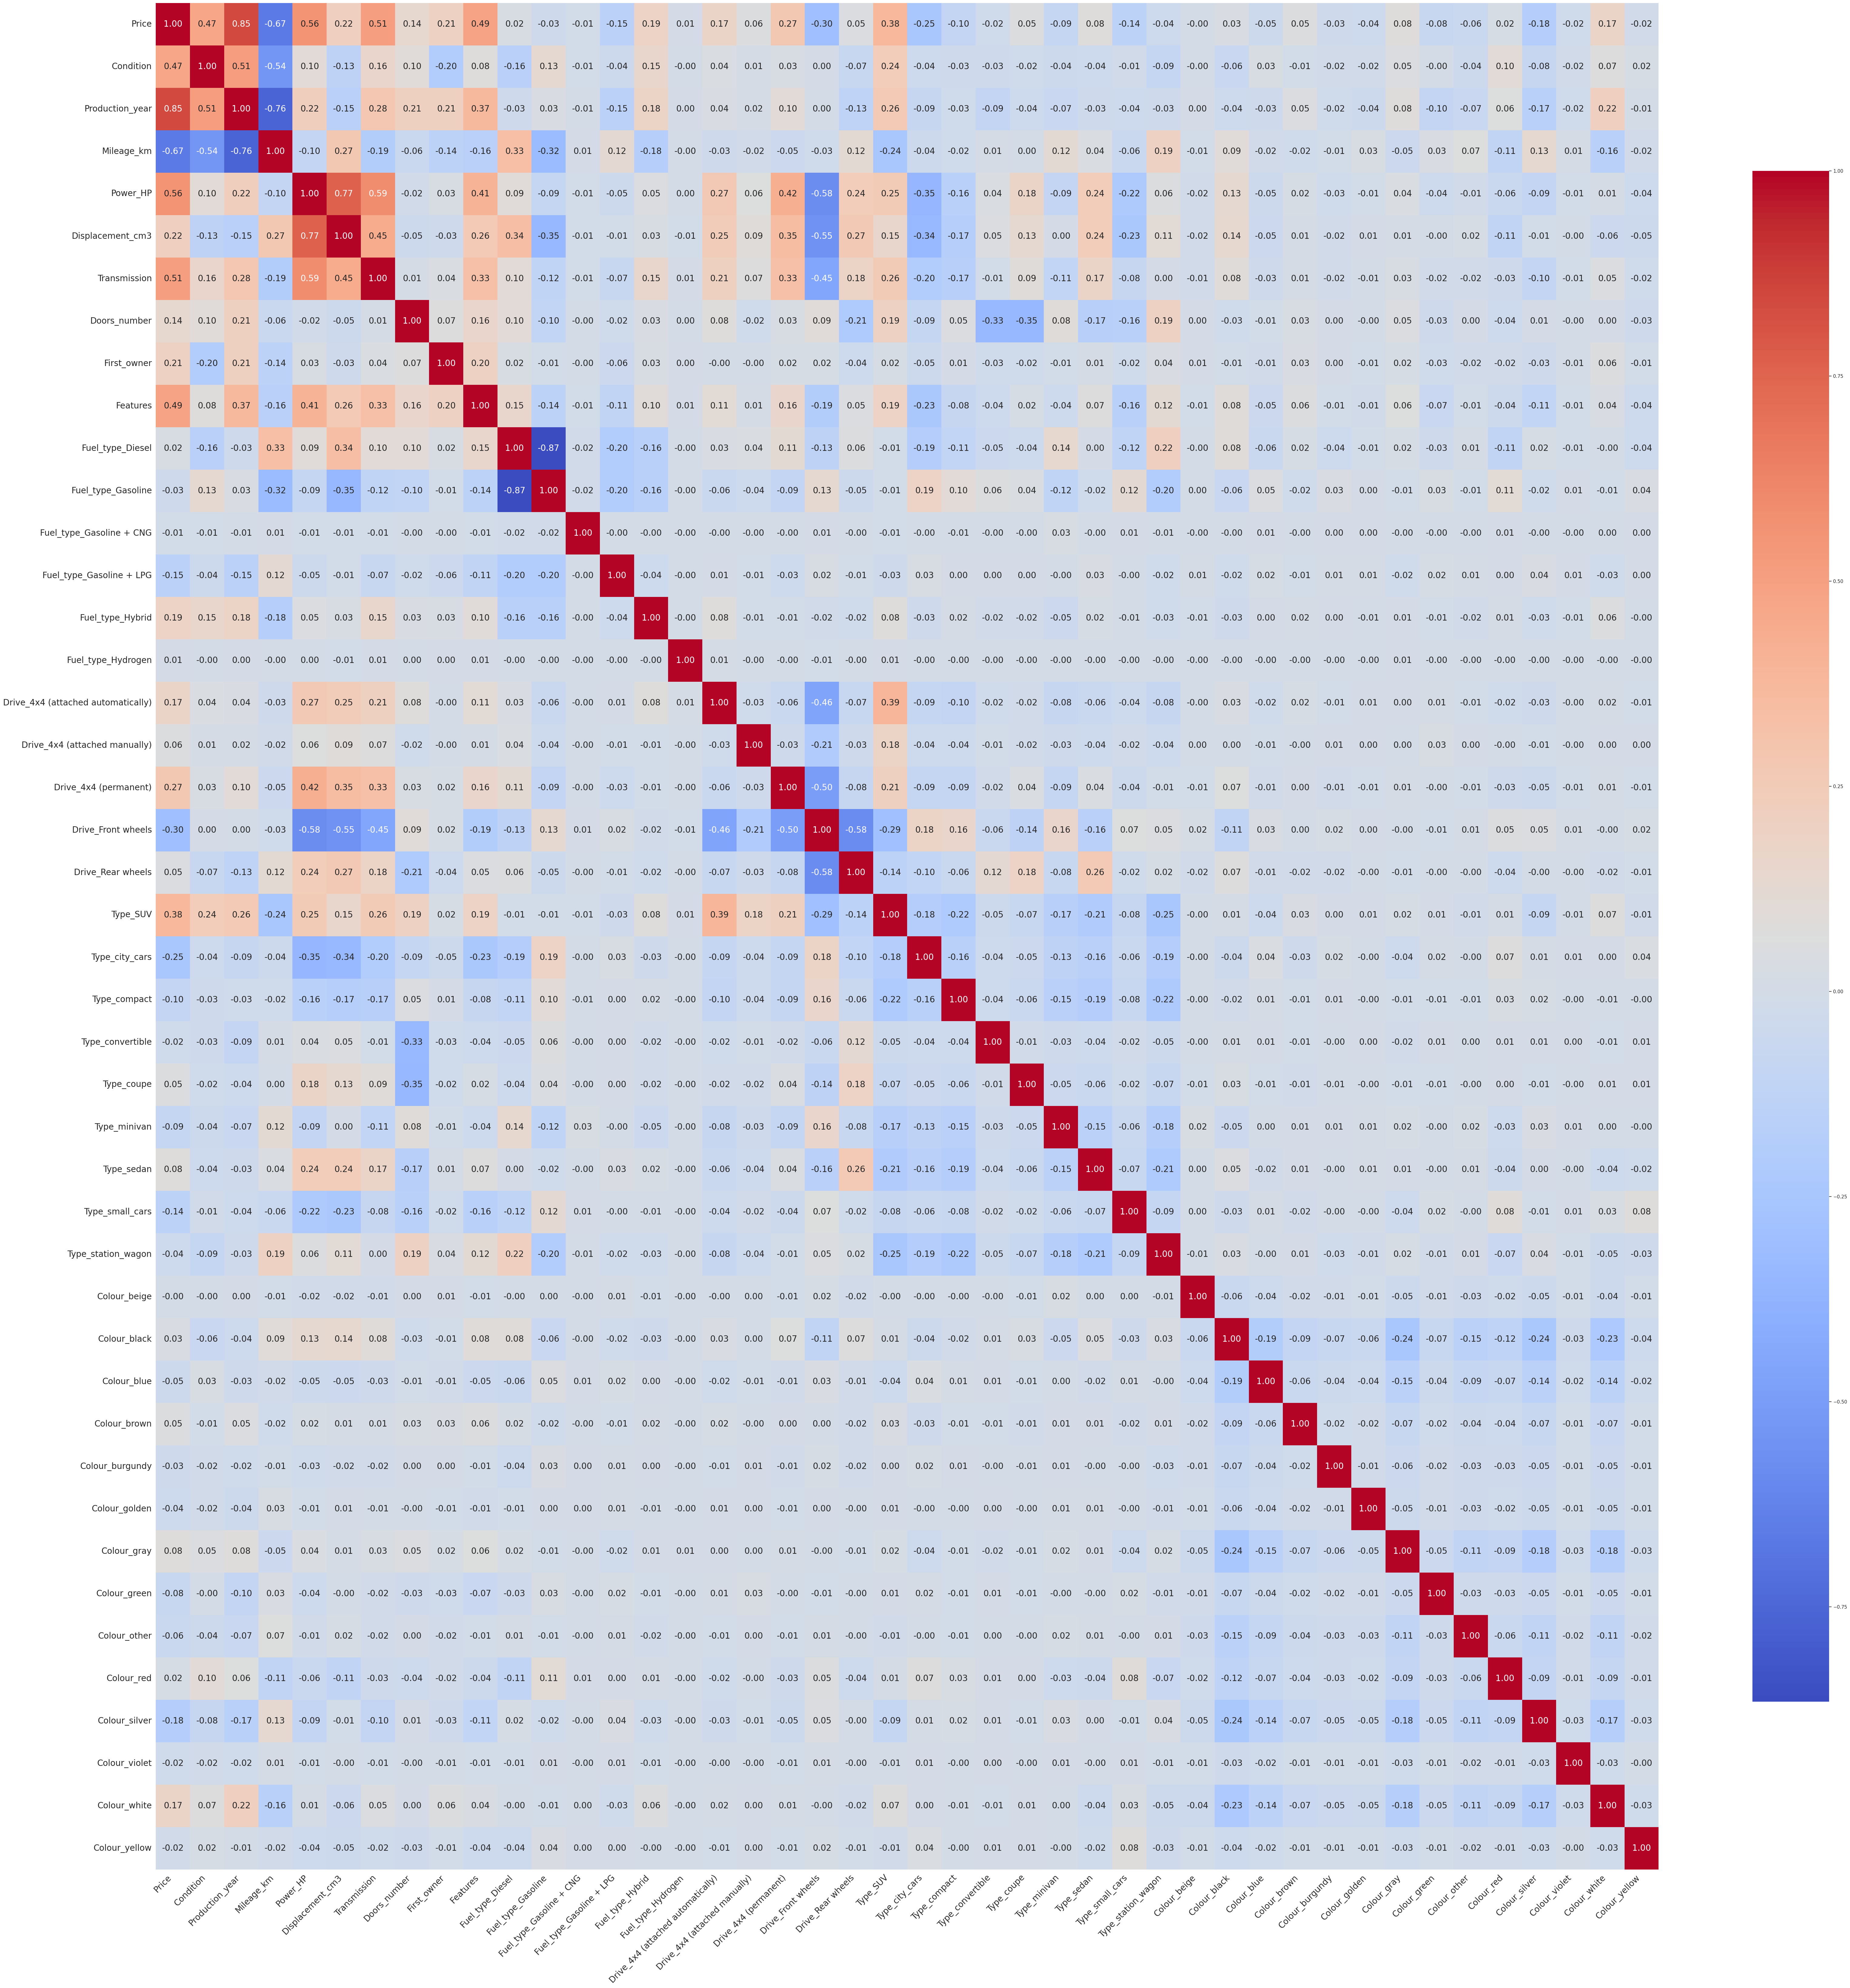

In [68]:
# Tworzenie heatmapy bez kolumn zaczynających się od 'brand_model'
columns_to_exclude = [col for col in df.columns if col.startswith('brand_model') or col.startswith('Offer_location')]
df_filtered = df.drop(columns=columns_to_exclude)

# Obliczanie macierzy korelacji
plt.figure(figsize=(80, 80))  # Zwiększ rozmiar obrazu
heatmap = sns.heatmap(df_filtered.corr(), annot=True, fmt=".2f", cmap='coolwarm',
                      cbar_kws={'shrink': .82},
                      annot_kws={'size': 20})

heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize=20, rotation=45, ha='right')
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize=20)
plt.show()


In [69]:
# Identyfikacja wszystkich kolumn zaczynających się od "Drive_4x4"
drive_4x4_columns = [col for col in df.columns if col.startswith("Drive_4x4")]

# Sumowanie tych kolumn w rzędach, aby utworzyć nową kolumnę "4x4".
df["Drive_4x4"] = df[drive_4x4_columns].sum(axis=1)

# Usunięcie oryginalnych kolumn "Drive_4x4" z ramki danych
df.drop(columns=drive_4x4_columns, inplace=True)

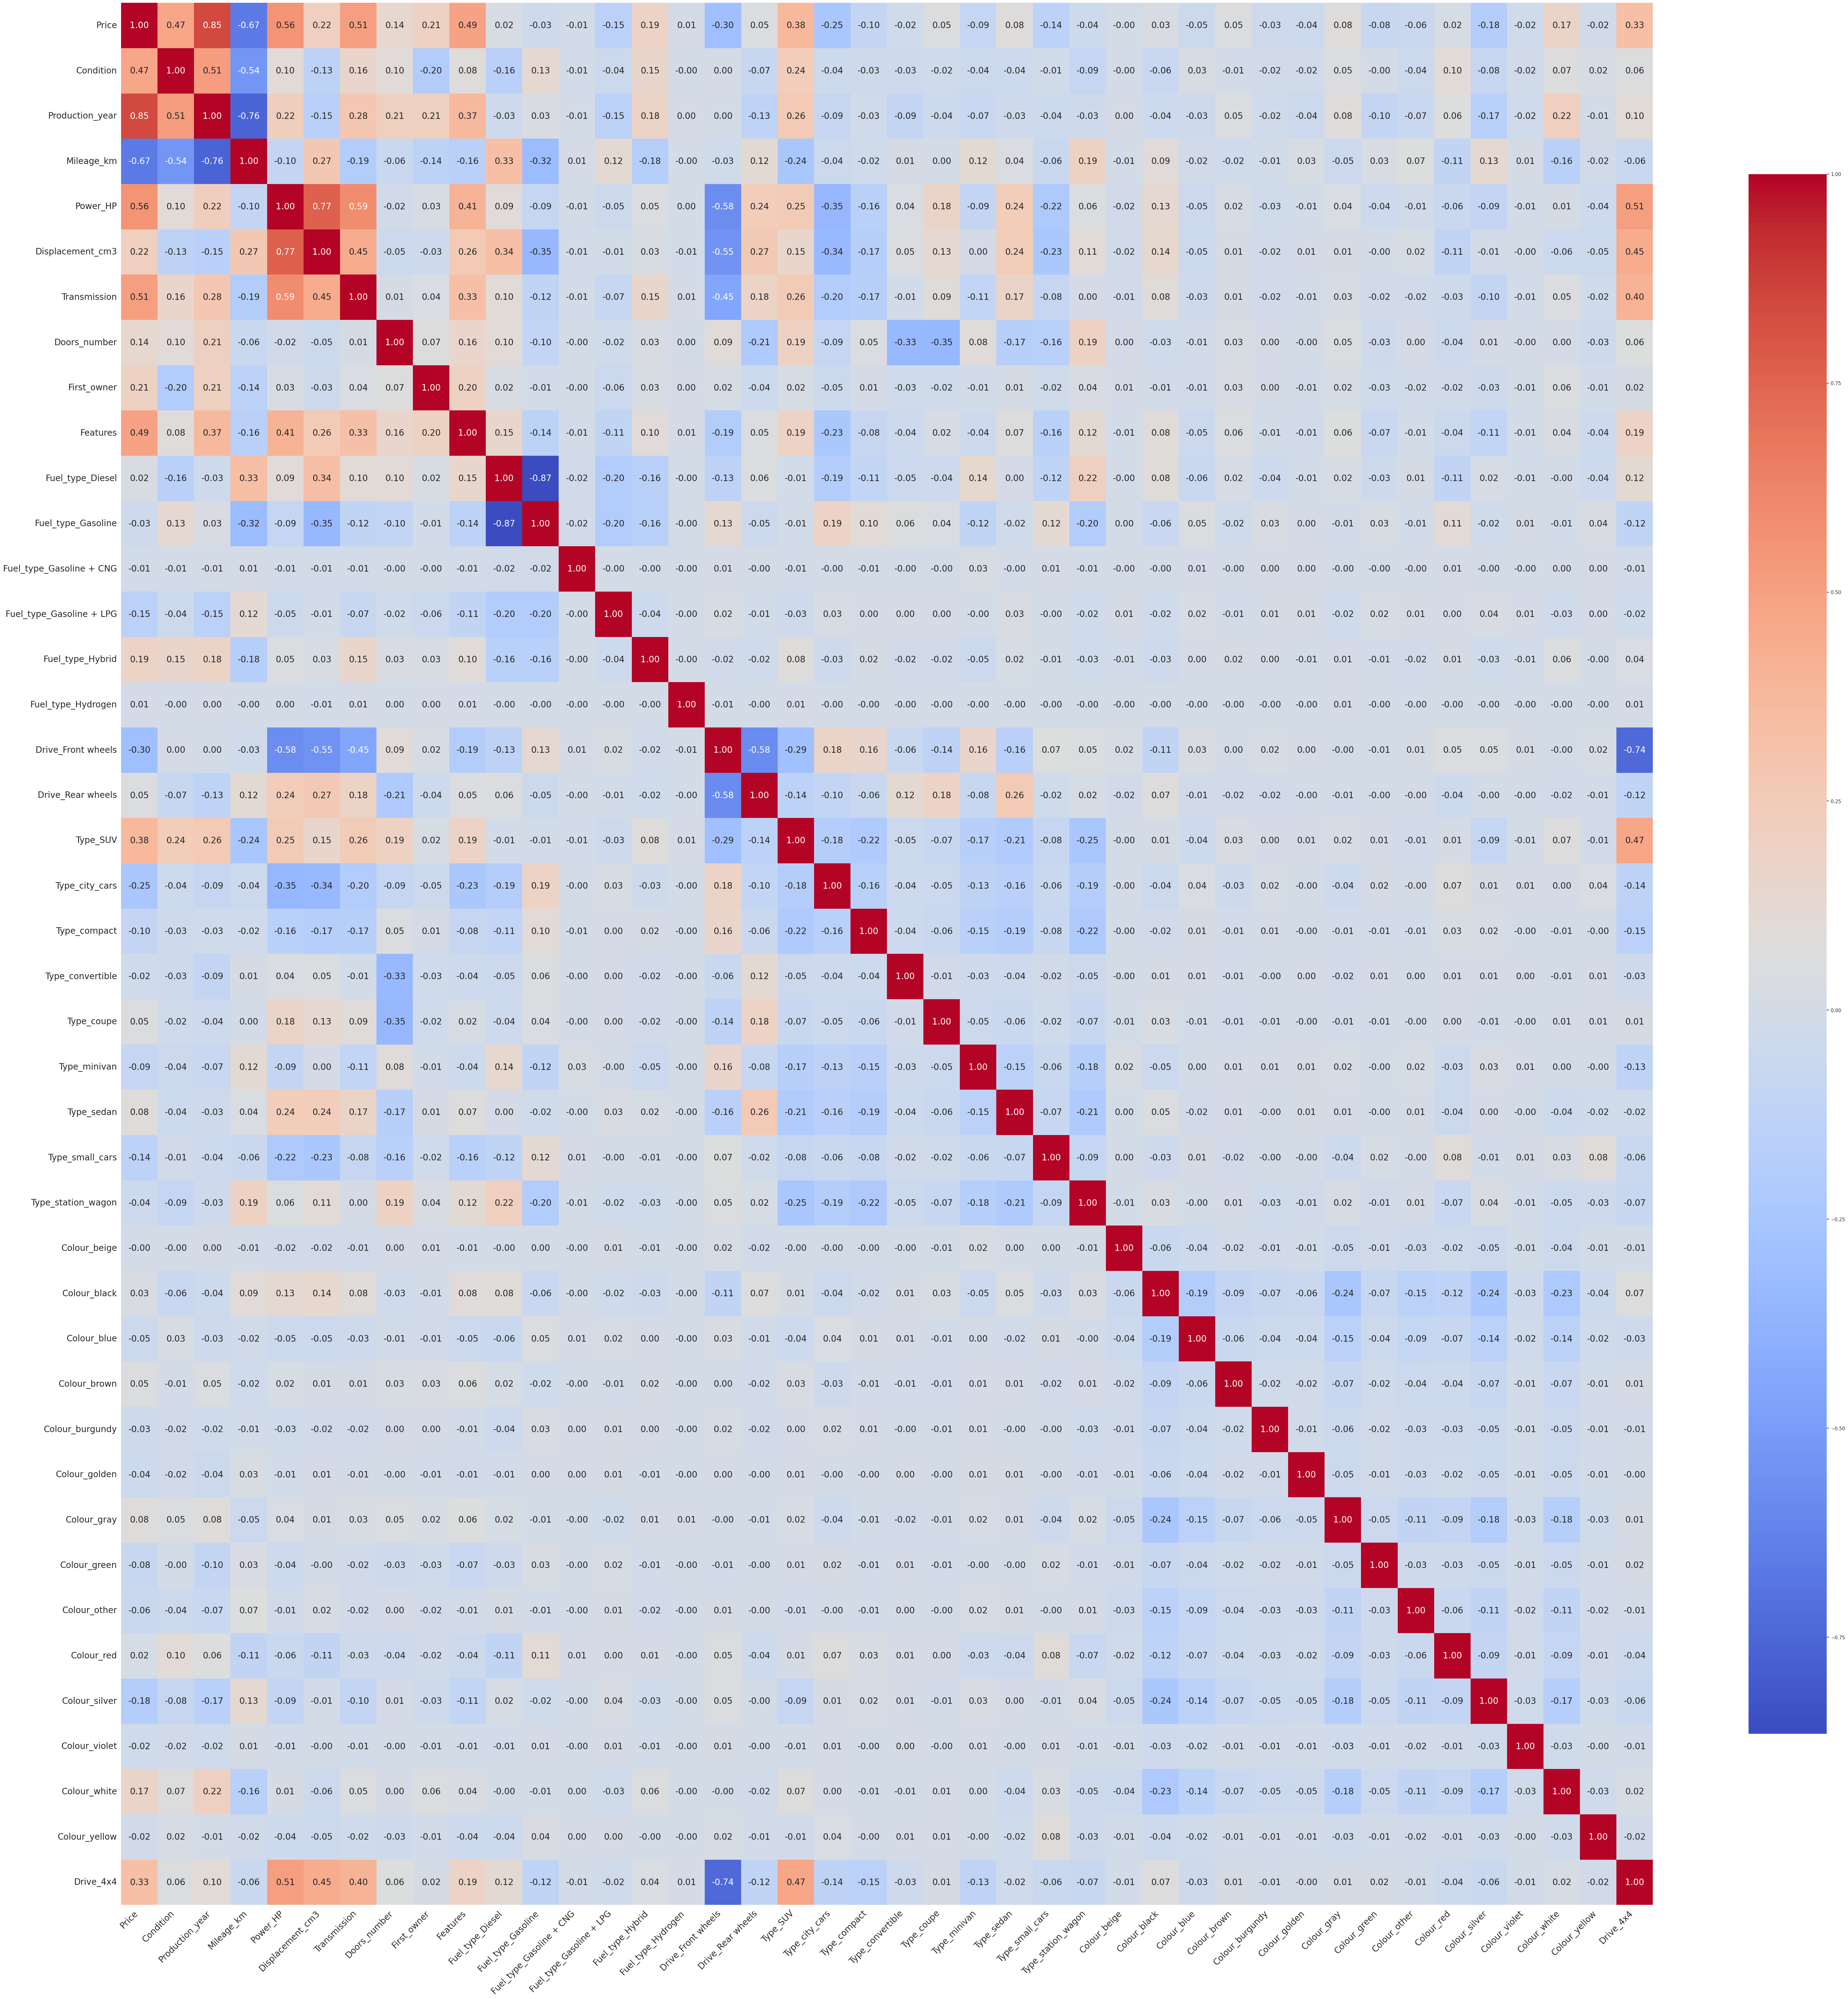

In [70]:

# Tworzenie heatmapy bez kolumn zaczynających się od 'brand_model'
columns_to_exclude = [col for col in df.columns if col.startswith('brand_model') or col.startswith('Offer_location')]
df_filtered = df.drop(columns=columns_to_exclude)

# Obliczanie macierzy korelacji
plt.figure(figsize=(80, 80))  # Zwiększ rozmiar obrazu
heatmap = sns.heatmap(df_filtered.corr(), annot=True, fmt=".2f", cmap='coolwarm',
                      cbar_kws={'shrink': .82},
                      annot_kws={'size': 20})

heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize=20, rotation=45, ha='right')
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize=20)
plt.show()


In [71]:
df.shape

(192589, 53)

In [72]:
# Obliczenie macierzy korelacji dla ramki danych
correlation_matrix = df.corr()

# Znalezienie kolumn z korelacją do "Price" w określonym zakresie (od -0,5 do 0,5), z wyłączeniem kolumn zaczynających się od "brand_model_".
columns_to_remove = correlation_matrix.index[(correlation_matrix["Price"] > -0.1) & (correlation_matrix["Price"] < 0.1) & (~correlation_matrix.index.str.startswith("brand_model_"))].tolist()

# Usunięcie tych kolumn z ramki danych
df = df.drop(columns=columns_to_remove)

In [73]:
df.shape

(192589, 30)

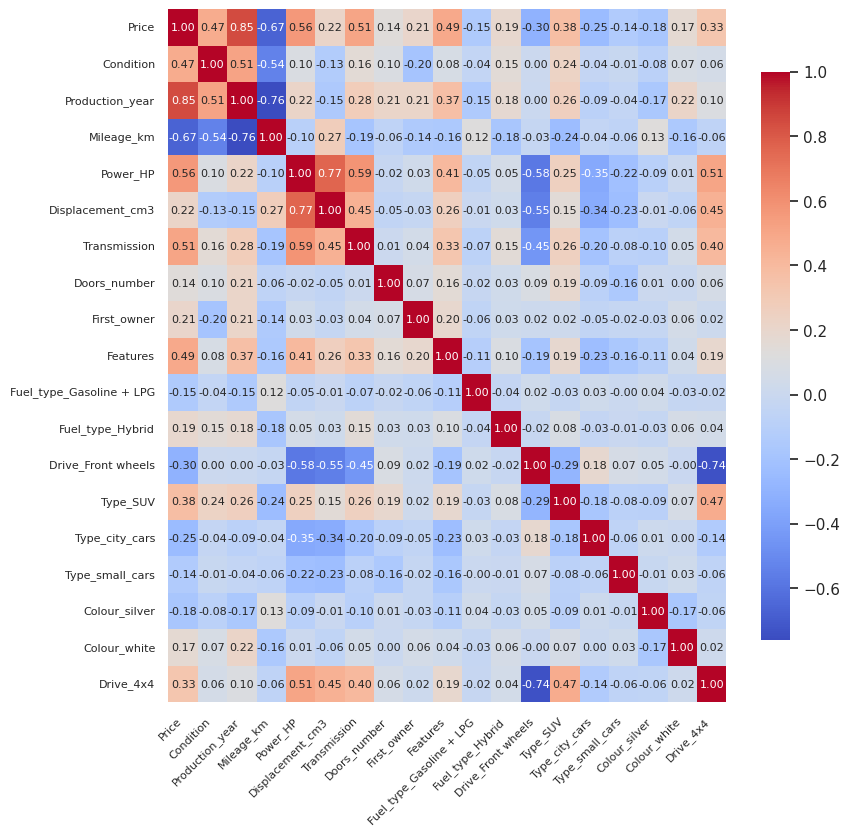

In [74]:
# Tworzenie heatmapy bez kolumn zaczynających się od 'brand_model'
columns_to_exclude = [col for col in df.columns if col.startswith('brand_model')]
df_filtered = df.drop(columns=columns_to_exclude)

# Obliczanie macierzy korelacji
plt.figure(figsize=(9, 9))  # Zwiększ rozmiar obrazu
heatmap = sns.heatmap(df_filtered.corr(), annot=True, fmt=".2f", cmap='coolwarm',
                      cbar_kws={'shrink': .82},
                      annot_kws={'size': 8})

heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize=8, rotation=45, ha='right')
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize=8)
plt.show()


In [75]:
df.shape

(192589, 30)

In [76]:
df.nunique()

Price                       12368
Condition                       2
Production_year                30
Mileage_km                  49230
Power_HP                      335
Displacement_cm3              630
Transmission                    2
Doors_number                    4
First_owner                     2
Features                       70
brand_model_0                   2
brand_model_1                   2
brand_model_2                   2
brand_model_3                   2
brand_model_4                   2
brand_model_5                   2
brand_model_6                   2
brand_model_7                   2
brand_model_8                   2
brand_model_9                   2
brand_model_10                  2
Fuel_type_Gasoline + LPG        2
Fuel_type_Hybrid                2
Drive_Front wheels              2
Type_SUV                        2
Type_city_cars                  2
Type_small_cars                 2
Colour_silver                   2
Colour_white                    2
Drive_4x4     

In [77]:
# Inicjalizacja skalera MinMaxScaler
scaler = MinMaxScaler()

# Przeskalowanie wszystkich wartości do przedziału 0-1
data_scaled = scaler.fit_transform(df)

# Konwersja przeskalowanych danych z powrotem do DataFrame
df = pd.DataFrame(data_scaled, columns=df.columns)

# Wyświetlenie pierwszych kilku wierszy przeskalowanych danych
df.head()

Price  Condition  Production_year  Mileage_km  Power_HP   
0  0.643278        1.0         1.000000    0.000000  0.385027  \
1  0.538052        0.0         0.896552    0.121210  0.478610   
2  0.519005        0.0         0.689655    0.067597  0.425134   
3  0.663812        1.0         1.000000    0.001396  0.438503   
4  0.592567        0.0         0.827586    0.107364  0.478610   

   Displacement_cm3  Transmission  Doors_number  First_owner  Features  ...   
0          0.319387           0.0      0.333333          0.0  0.000000  ...  \
1          0.309166           0.0      0.333333          0.0  0.289855  ...   
2          0.309166           0.0      0.333333          0.0  0.318841  ...   
3          0.309166           0.0      0.333333          0.0  0.347826  ...   
4          0.309166           0.0      0.333333          1.0  0.420290  ...   

   brand_model_10  Fuel_type_Gasoline + LPG  Fuel_type_Hybrid   
0             1.0                       0.0               0.0  \
1             1.0                       0.0               0.0   
2             1.0                       0.0               0.0   
3             1.0                       0.0               0.0   
4             1.0                       0.0               0.0   

   Drive_Front wheels  Type_SUV  Type_city_cars  Type_small_cars   
0                 1.0       0.0             0.0              1.0  \
1                 1.0       0.0             0.0              1.0   
2                 1.0       0.0             0.0              1.0   
3                 1.0       0.0             0.0              1.0   
4                 1.0       0.0             0.0              1.0   

   Colour_silver  Colour_white  Drive_4x4  
0            0.0           0.0        0.0  
1            1.0           0.0        0.0  
2            0.0           0.0        0.0  
3            0.0           0.0        0.0  
4            0.0           0.0        0.0  

[5 rows x 30 columns]

# Wybór i implementacja wybranych modeli predykcyjnych

### Podział danych na zbiór treningowy i testowy

In [78]:
X = df.drop(columns=['Price'])
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Trenowanie modelu regresji liniowej

In [80]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr=r2_score(y_test, y_pred_lr)

r2_lr, mse_lr, mae_lr


(0.9041541796369932, 0.002485601547070173, 0.03538407030525179)

### Trenowanie modelu drzewa decyzyjnego

In [81]:
model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt=r2_score(y_test, y_pred_dt)
r2_dt, mse_dt, mae_dt


(0.8964730817554107, 0.0026847980139098225, 0.033568598616041674)

### Trenowanie modelu XGBoost

In [82]:
model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb=r2_score(y_test, y_pred_xgb)
r2_xgb, mse_xgb, mae_xgb


(0.9446178624387727, 0.0014362433988344362, 0.025755880335552362)

### Trenowanie modelu LightGBM

In [83]:
model_lgbm = LGBMRegressor(n_estimators=100, random_state=42)
model_lgbm.fit(X_train, y_train)
y_pred_lgbm = model_lgbm.predict(X_test)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
r2_lgbm=r2_score(y_test, y_pred_lgbm)
r2_lgbm, mse_lgbm, mae_lgbm

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 792
[LightGBM] [Info] Number of data points in the train set: 154071, number of used features: 29
[LightGBM] [Info] Start training from score 0.495185


(0.9386487107672016, 0.001591043395050861, 0.027838630141278686)

## Trenowanie modelu sieci neuronowej (MLPRegressor)

In [84]:
model_mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42, solver='adam')
model_mlp.fit(X_train, y_train)
y_pred_mlp = model_mlp.predict(X_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
r2_mlp=r2_score(y_test, y_pred_mlp)
r2_mlp, mse_mlp, mae_mlp

(0.9344786468906356, 0.001699187048928693, 0.0282213388463126)

### Trenowanie modelu k-NN

In [85]:
model_knn = KNeighborsRegressor(n_neighbors=5) # Możesz dostosować liczbę sąsiadów
model_knn.fit(X_train, y_train)

# Predykcja na zestawie testowym
y_pred_knn = model_knn.predict(X_test)

# Obliczanie metryk
mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

# Wyświetlanie wyników
r2_knn, mse_knn, mae_knn


(0.9145864757808998, 0.002215057340378852, 0.031570252933006394)

In [86]:
# Przykładowe wartości MSE - proszę zastąpić rzeczywistymi wynikami, jeśli są dostępne
mse_values_example = {
    "Linear Regression": mse_lr,
    "Decision Tree": mse_dt,
    "XGBoost": mse_xgb,  # Zakładając, że taki wynik został uzyskany
     "LGBMRegressor": mse_lgbm,  # Pominięto ze względu na problemy z pamięcią
    "MLPRegressor": mse_mlp,  # Zakładana wartość
    "K-NN": mse_knn
}

# Przykładowe wartości R^2 - proszę zastąpić rzeczywistymi wynikami, jeśli są dostępne
r2_values_example = {
    "Linear Regression": r2_lr,
    "Decision Tree": r2_dt,
    "XGBoost": r2_xgb,
     "LGBMRegressor": r2_lgbm,  # Pominięto ze względu na problemy z pamięcią
    "MLPRegressor": r2_mlp,
    "K-NN": r2_knn
}
mae_values_example = {
    "Linear Regression": mae_lr,
    "Decision Tree": mae_dt,
    "XGBoost": mae_xgb,
     "LGBMRegressor": mae_lgbm,  # Pominięto ze względu na problemy z pamięcią
    "MLPRegressor": mae_mlp,
    "K-NN": mae_knn
}

# Wyświetlenie tabeli z wartościami MSE oraz R^2 dla każdego modelu
results_df = pd.DataFrame({
    "Model": list(mse_values_example.keys()),
    "MSE": list(mse_values_example.values()),
    "MAE": list(mae_values_example.values()),
    "R^2": list(r2_values_example.values())
})

results_df

Model       MSE       MAE       R^2
0  Linear Regression  0.002486  0.035384  0.904154
1      Decision Tree  0.002685  0.033569  0.896473
2            XGBoost  0.001436  0.025756  0.944618
3      LGBMRegressor  0.001591  0.027839  0.938649
4       MLPRegressor  0.001699  0.028221  0.934479
5               K-NN  0.002215  0.031570  0.914586

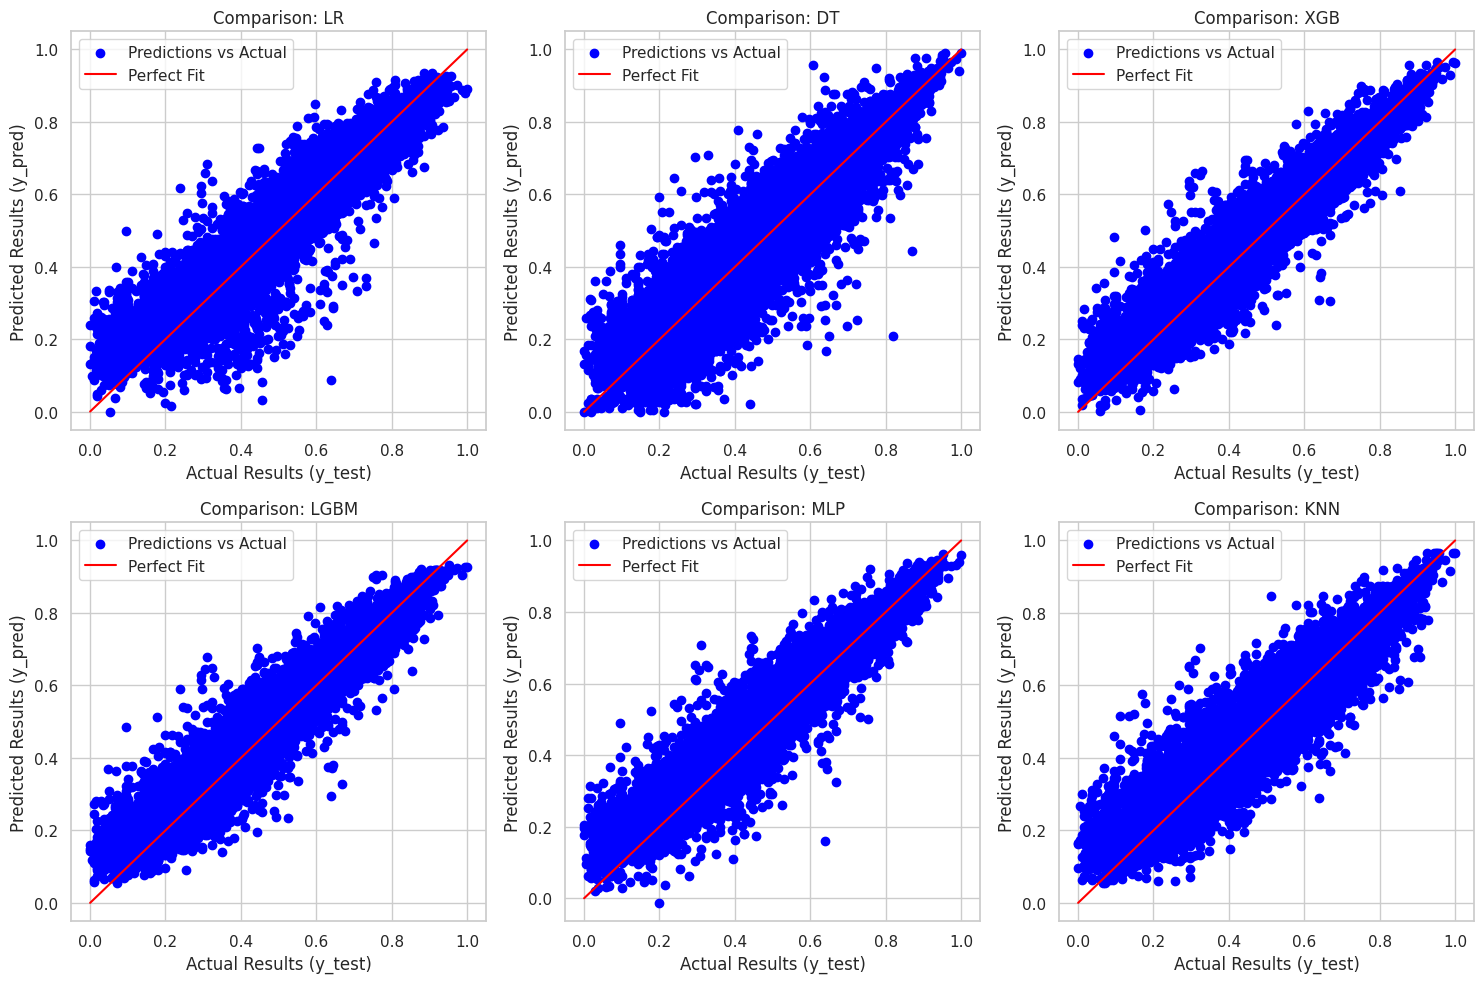

In [87]:
predictions = [y_pred_lr, y_pred_dt, y_pred_xgb, y_pred_lgbm, y_pred_mlp, y_pred_knn ]
labels = ['LR', 'DT', 'XGB', 'LGBM', 'MLP','KNN']

plt.figure(figsize=(15, 10))

for i, (pred, label) in enumerate(zip(predictions, labels), 1):
    plt.subplot(2, 3, i)
    plt.scatter(y_test, pred, color='blue', label='Predictions vs Actual')
    plt.title(f'Comparison: {label}')
    plt.xlabel('Actual Results (y_test)')
    plt.ylabel('Predicted Results (y_pred)')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Perfect Fit')
    plt.legend()

plt.tight_layout()
plt.show()